In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
# I was getting a ModuleNotFoundError, and I discovered that the cwd (current working directory) was
#   '<Github Home>/market-modeling/examples/' but it needs to be '<Github Home>/market-modeling/'
# The following code will add the cwd's parent directory to the path Python uses to search for packages
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import os
from datetime import datetime

from models.gbm_models.Models import DependentCovariateModel
from markets.Markets import Market
from assets.Assets import HeirarchicalAsset
from metrics.Metrics import VarType, TimeseriesMetric, StaticMetric
from markets.DerivedVariables import EWMATransform, ScaledDeltaLogTransform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, Normalize

In [4]:
DEBUG = False
DATA_DIR = '../data'
MARKET_NAME = 'popular_stocks'
TS_DIR = 'growth_timeseries'

In [5]:
asset_list = []
asset_metadata = pd.read_csv(os.path.join(DATA_DIR, MARKET_NAME, 'asset_metadata.tsv'), sep='\t')

for i, row in asset_metadata.iterrows():
  if DEBUG:
    if i == 5:
      break
  
  asset_ts = pd.read_csv(
    os.path.join(DATA_DIR, MARKET_NAME, TS_DIR, f"{row['id']}.csv"),
    parse_dates=['date'],
    dtype={'price' : np.float32}
  )
  
  asset = HeirarchicalAsset(
    row['name'],
    row['id'],
    {
      'signal': TimeseriesMetric(asset_ts['date'], asset_ts['price'], VarType.QUANTITATIVE),
	  'sector_id': StaticMetric(row['sector'], VarType.CATEGORICAL),
	  'industry_id': StaticMetric(row['industry'], VarType.CATEGORICAL)
    }
  )
  asset_list.append(asset)

market = Market(asset_list, MARKET_NAME)
market.align_timeseries(True)

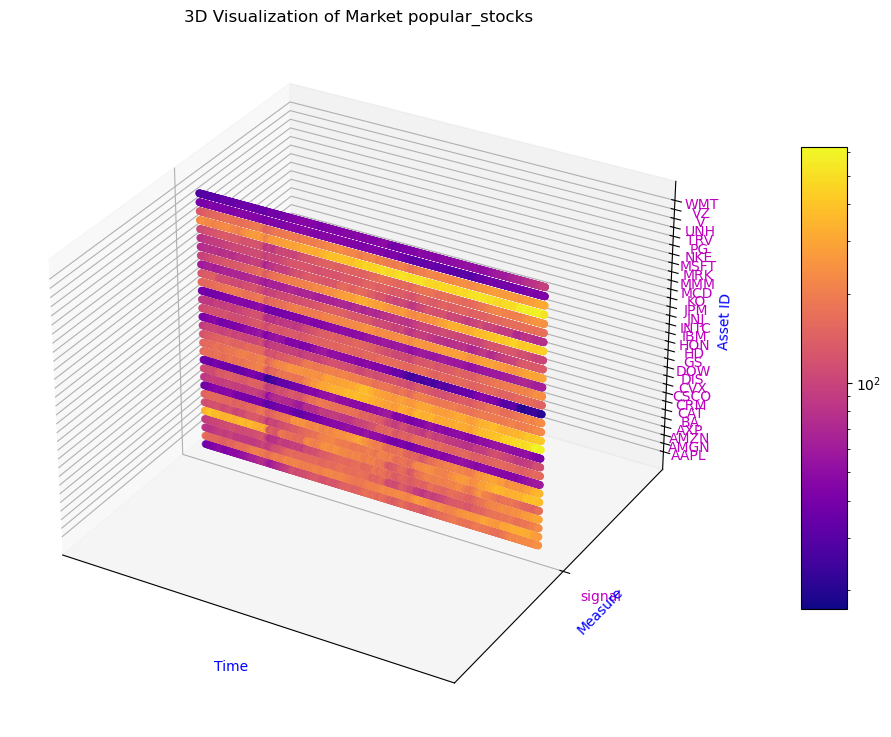

In [6]:
market.display_market()

In [7]:
# add covariates for moving averages of `signal`
ewma_trans7 = EWMATransform(days=7)
ewma_trans30 = EWMATransform(days=30)
# add covariates for delta ln(avg_signal) for using the base signal and the average signals specified above
deltalog_signal = ScaledDeltaLogTransform()
deltalog_7davg = ScaledDeltaLogTransform(var_to_transf=ewma_trans7.op_name)
deltalog_30davg = ScaledDeltaLogTransform(var_to_transf=ewma_trans30.op_name)
# create columns in the market's dataset for these covariates
market.register_derived_var(ewma_trans7)
market.register_derived_var(ewma_trans30)
market.register_derived_var(deltalog_signal)
market.register_derived_var(deltalog_7davg)
market.register_derived_var(deltalog_30davg)

# One/Multi hot encode hierarchical info
market.encode_indicators(True, ',')

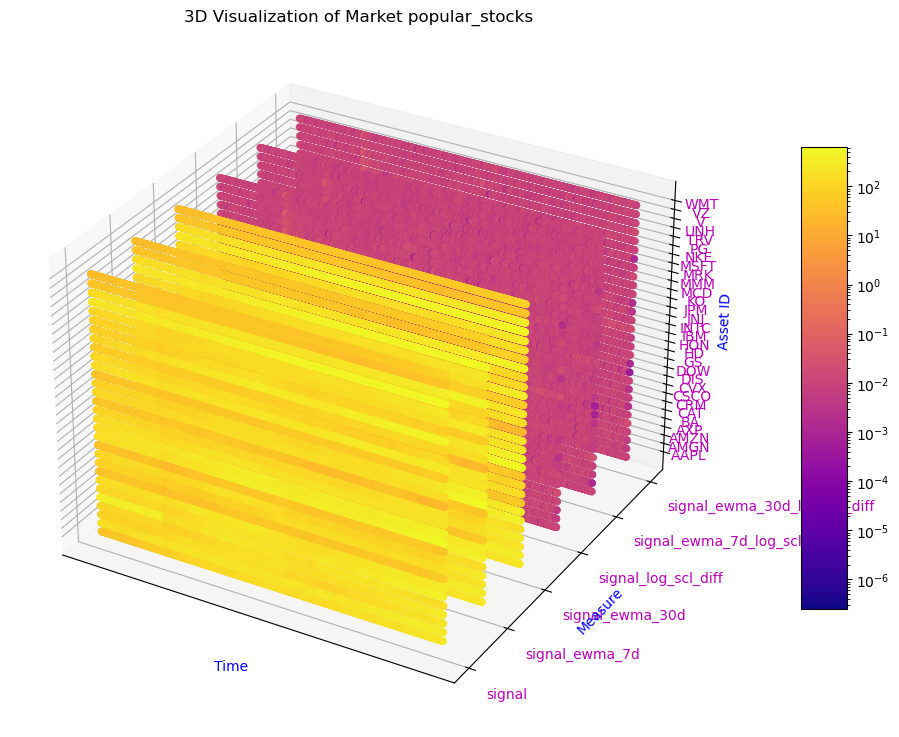

In [8]:
market.display_market(show_indicators=False)

In [9]:
mkt_var_names = market.get_var_names()

In [10]:
dep_cov_model = DependentCovariateModel(
	market,
	covar_vars=['signal_log_scl_diff', 'signal_ewma_7d_log_scl_diff', 'signal_ewma_30d_log_scl_diff', 'sector_id_technology', 'sector_id_healthcare', 'sector_id_consumer-cyclical', 'sector_id_financial-services', 'sector_id_industrials', 'sector_id_energy', 'sector_id_communication-services', 'sector_id_basic-materials', 'sector_id_consumer-defensive', 'industry_id_consumer-electronics', 'industry_id_drug-manufacturers-general', 'industry_id_internet-retail', 'industry_id_credit-services', 'industry_id_aerospace-defense', 'industry_id_farm-heavy-construction-machinery', 'industry_id_software-application', 'industry_id_communication-equipment', 'industry_id_oil-gas-integrated', 'industry_id_entertainment', 'industry_id_chemicals', 'industry_id_capital-markets', 'industry_id_home-improvement-retail', 'industry_id_conglomerates', 'industry_id_information-technology-services', 'industry_id_semiconductors', 'industry_id_banks-diversified', 'industry_id_beverages-non-alcoholic', 'industry_id_restaurants', 'industry_id_software-infrastructure', 'industry_id_footwear-accessories', 'industry_id_household-personal-products', 'industry_id_insurance-property-casualty', 'industry_id_healthcare-plans', 'industry_id_telecom-services', 'industry_id_discount-stores']
)

In [11]:
dep_cov_model.estimate_parameters()

100%|██████████| 200/200 [03:09<00:00,  1.05it/s, loss=2.01e+6, MAE=0.307]


In [12]:
df_results = pd.DataFrame({
  'id' : market.xarray_ds.ID.values,
  'drifts' : dep_cov_model.drifts,
  'vols' : np.linalg.norm(dep_cov_model.get_correlation_mat(), axis=0)**2
})

df_results

,id,drifts,vols
0,AAPL,4.370663e-04,5.519140e-06
1,AMGN,4.855425e-04,3.950247e-06
2,AMZN,4.210701e-04,6.589832e-06
3,AXP,5.016891e-04,1.164966e-05
4,BA,1.199144e-03,2.212310e-05
5,CAT,8.407528e-04,1.004995e-05
6,CRM,1.087547e-03,1.397125e-05
7,CSCO,1.016240e-04,8.221279e-06
8,CVX,8.198346e-04,1.199420e-05
9,DIS,5.550773e-04,1.174320e-05


In [13]:
dep_cov_model.summarize_covariate_distributions()

signal_log_scl_diff		-0.0253
signal_ewma_7d_log_scl_diff		-0.0179
signal_ewma_30d_log_scl_diff		-0.0229
sector_id_technology		0.0004
sector_id_healthcare		0.0001
sector_id_consumer-cyclical		0.0002
sector_id_financial-services		0.0002
sector_id_industrials		-0.0005
sector_id_energy		0.0003
sector_id_communication-services		0.0005
sector_id_basic-materials		0.0007
sector_id_consumer-defensive		-0.0002
industry_id_consumer-electronics		0.0009
industry_id_drug-manufacturers-general		0.0007
industry_id_internet-retail		0.0013
industry_id_credit-services		0.0005
industry_id_aerospace-defense		0.0004
industry_id_farm-heavy-construction-machinery		0.0010
industry_id_software-application		0.0005
industry_id_communication-equipment		0.0006
industry_id_oil-gas-integrated		0.0001
industry_id_entertainment		0.0000
industry_id_chemicals		-0.0004
industry_id_capital-markets		0.0002
industry_id_home-improvement-retail		0.0007
industry_id_conglomerates		0.0017
industry_id_information-technology-servic

<Figure size 640x480 with 0 Axes>

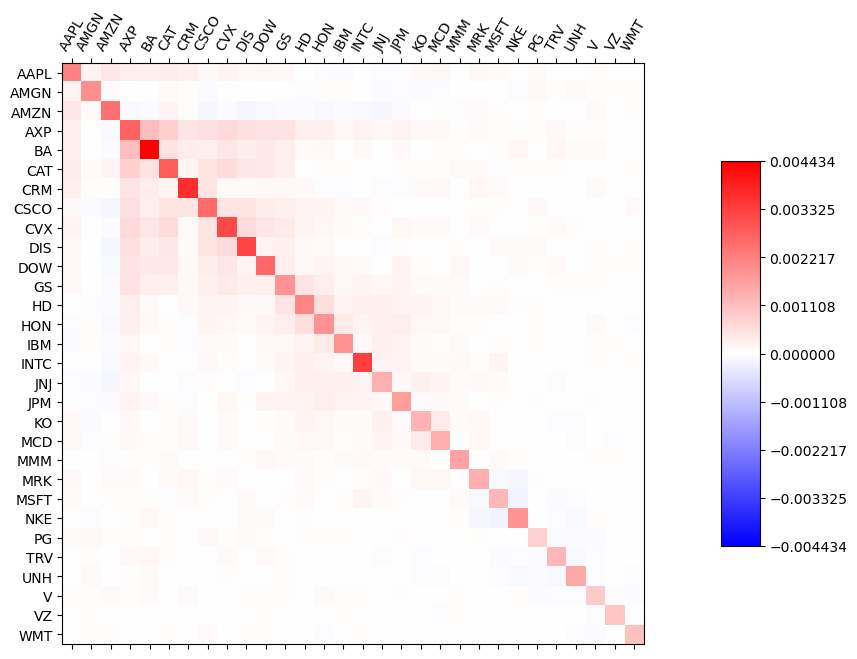

In [41]:
Sigma = dep_cov_model.get_correlation_mat()

# define a linear color map
max_magn_val = max(Sigma.min(), Sigma.max())
plt.set_cmap('bwr')
cust_cmap = Normalize(-max_magn_val, max_magn_val)

fig, ax = plt.subplots(figsize=(10, 10))
colors = ax.matshow(Sigma, norm=cust_cmap)
ax.set_xticks(np.arange(Sigma.shape[0]), labels=market.xarray_ds['ID'].values, rotation=60)
ax.set_yticks(np.arange(Sigma.shape[1]), labels=market.xarray_ds['ID'].values)
cbar = fig.colorbar(colors, ax=ax, shrink=0.5, aspect=10, pad=0.1, label='', alpha=0.5)
cbar.set_ticks(np.linspace(cust_cmap.vmin, cust_cmap.vmax, 9));

In [17]:
dates_to_sim = pd.to_datetime(
  pd.Series(['01-24-2025', '01-27-2025', '01-28-2025', '01-29-2025'], name='dates'),
  format='%m-%d-%Y'
)

prev_time, prev_state = market.get_market_state_before_date(min(dates_to_sim))
prev_signals = prev_state.sel(variable='signal').to_numpy()

sim_dates = pd.concat((pd.Series(prev_time, name='dates'), dates_to_sim))

In [21]:
sim_res = dep_cov_model.simulate(prev_signals, sim_dates, num_sims=20)
sim_counterfact = dep_cov_model.simulate(prev_signals, sim_dates, 1, add_BM=False)

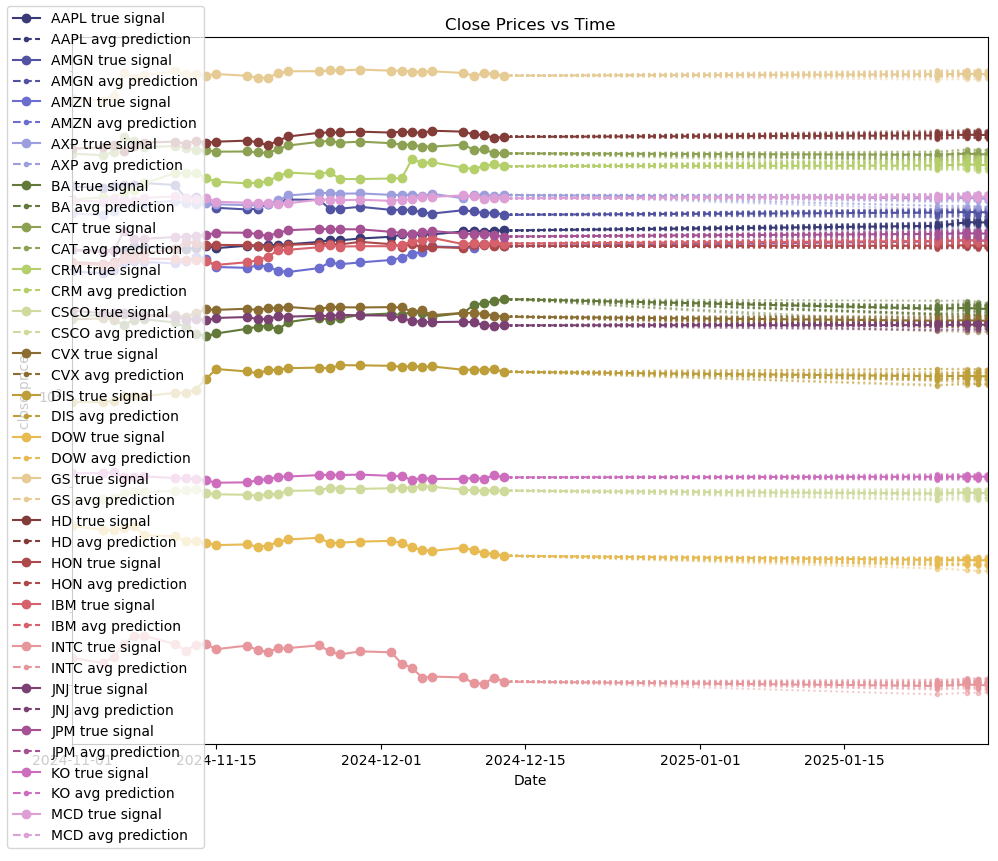

In [22]:
import matplotlib as mpl
colorscheme = mpl.colormaps['tab20b']
fig, ax = plt.subplots(figsize=(10,8))

xarr = market.get_dataarray()

for i in range(colorscheme.N):
  asset_i_id = xarr.isel(ID=i)['ID'].values
  # plot true observations
  ax.plot(
    xarr.time, xarr.sel(ID=asset_i_id, variable='signal'),
    '-o', color=colorscheme.colors[i % colorscheme.N],
    label=f'{asset_i_id} true signal'
  )
  # plot simulated predictions w/o GBM
  ax.plot(
    sim_dates, sim_counterfact[0, i, :],
    color=colorscheme.colors[i % colorscheme.N], marker='.', linestyle='dashed',
    label=f'{asset_i_id} avg prediction'
  )
	# plot simulated predictions w/ GBM
  for j_sim in range(sim_res.shape[0]):
    ax.plot(
      sim_dates, sim_res[j_sim, i, :],
      alpha=0.5, color=colorscheme.colors[i % colorscheme.N], linestyle='dotted', marker='.'
    )
ax.set_xlim([datetime(2024, 11, 1), sim_dates.max()])
ax.set(xlabel='Date', ylabel='close price', title='Close Prices vs Time')
ax.set_yscale('log')
fig.tight_layout()
fig.legend(loc=2);